In [10]:
#in this file, I will create and save a variety of new dataframes with new features
#these features are engineered features, designed in the hope of improving model performance 
#at this stage, I am still only looking at the first timeslice of the data. This file will be within that context. 
#The output dataframes will be the first (full, including where there is no ice) time slice, plus the extra features. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.metrics import mean_squared_error

df = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])

def scale (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

def scale_except_target(df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns[:-1]:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df



def unscale_rmse(scaled_rmse, target_name, original_df):
    target_min = original_df[target_name].min()
    target_max = original_df[target_name].max()

    return scaled_rmse * (target_max - target_min)

#df = scale(df)
df.head()

,x-axis,y-axis,ice_thickness,ice_velocity,ice_mask,precipitation,air_temp,ocean_temp
0,-3040000,3040000,0.0,NaN,4,729.484314,292.419525,9.969210e+36
1,-2918400,3040000,0.0,NaN,4,694.597717,273.805786,9.969210e+36
2,-2796800,3040000,0.0,NaN,4,692.034973,273.378845,9.969210e+36
3,-2675200,3040000,0.0,NaN,4,678.951782,272.875427,9.969210e+36
4,-2553600,3040000,0.0,NaN,4,659.565613,272.366669,9.969210e+36


In [3]:
#creating a feature to represent the (cartesian) distance from pole of each point 

def add_distance_from_pole(df):
    
    # Calculate the distance using the Euclidean distance formula
    df['dist'] = np.sqrt(df['x-axis']**2 + df['y-axis']**2)
    
    return df

In [4]:
#this feature represents the difference between ocean and air temperature 
#i thought it could aid in representing the interaction between atmposphere and sea, which is an important 
#factor in the behaviour of the ice sheet 

def add_temperature_difference(df):

    # Calculate the difference between ocean and air temperatures
    df['temp_diff'] = df['ocean_temp'] - df["air_temp"]
    
    return df

In [5]:
#this calculates the feature air_roll. This is the rolling average of the air temp across the coordinates, 
#with a window size of 1 (looks at the temps surrounding by 1 and takes the average)


def roll(df, window_size, col_to_roll, new_col_name):
    
    #initialise new column
    df[new_col_name] = np.nan
    
    #I am multiplying by this value, as this is the difference bewtween each x or y coordinate
    #using a window size of 2 means that the method will consider 2 coordinates out from each point now 
    #it just makes using the method a little more interpretable
    window_size=window_size*121600

    #iterate over the x and y coords to calculate the rolling average 
    for index, row in df.iterrows():
        window = df[(df['x-axis'] >= row['x-axis'] - window_size) & (df['x-axis'] <= row['x-axis'] + window_size) &
                (df['y-axis'] >= row['y-axis'] - window_size) & (df['y-axis'] <= row['y-axis'] + window_size)]
        

        df.at[index, new_col_name] = window[col_to_roll].mean()

    return df

#check/proof that it works - note, here the step needs to be 1/121600 because of the multiplication in the method 
data = {'x-axis': [1, 2, 3, 1, 2, 3, 1, 2, 3], 'y-axis': [5, 5, 5, 4, 4, 4, 3, 3, 3], 'temp': [10, 12, 13, 10, 14, 15, 12, 16, 16]}
df = pd.DataFrame(data)


roll_df_test = roll(df, 1/121600, "temp", "temp_roll")

roll_df_test.head()

,x-axis,y-axis,temp,temp_roll
0,1,5,10,11.500000
1,2,5,12,12.333333
2,3,5,13,13.500000
3,1,4,10,12.333333
4,2,4,14,13.111111


In [6]:
df = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])

df = add_distance_from_pole(df)
df = add_temperature_difference(df)
df = roll(df, 1, "air_temp", "air_roll")
df = roll(df, 1, "ocean_temp", "ocean_roll")
df = roll(df, 1, "precipitation", "precip_roll")
#not scaling here so I can scale in the RF part

EF_ice_thickness = df.drop(columns = ['ice_mask', 'ice_velocity'])
EF_ice_thickness.head()
EF_ice_thickness.to_csv('../data/AIS_data/EF_ice_thickness.csv', index = False)



df = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])

df = add_distance_from_pole(df)
df = add_temperature_difference(df)
df = roll(df, 3, "air_temp", "air_roll")
df = roll(df, 3, "ocean_temp", "ocean_roll")
df = roll(df, 3, "precipitation", "precip_roll")

EF_ice_velocity = df.drop(columns = ['ice_mask', 'ice_thickness'])
EF_ice_velocity.to_csv('../data/AIS_data/EF_ice_velocity.csv', index = False)


In [9]:
df = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])

#removing rows with placeholder ocean temp 
#i did not do this in the other two as I will only be looking at the area where there is ice in my regression
#of that data anyway. 

tolerance = 1e+30
df = df[(df['ocean_temp'] < (9.969210e+36 - tolerance))]

#removing rows where theres the random 0 for ice mask (its only like two)
df = df[df['ice_mask']>0] 

df = add_distance_from_pole(df)
df = add_temperature_difference(df)
df = roll(df, 1, "air_temp", "air_roll")
df = roll(df, 1, "ocean_temp", "ocean_roll")
df = roll(df, 1, "precipitation", "precip_roll")

df.to_csv('../data/AIS_data/EF_full_df.csv', index = False)
EF_ice_mask = df.drop(columns = ['ice_velocity', 'ice_thickness'])

#EF_ice_mask.to_csv('../data/AIS_data/EF_ice_mask.csv', index = False)

EF_ice_mask.head()





,x-axis,y-axis,ice_mask,precipitation,air_temp,ocean_temp,dist,temp_diff,air_roll,ocean_roll,precip_roll
14,-1337600,3040000,4,546.317932,266.901917,272.842255,3.321261e+06,5.940338,266.796100,272.832892,539.069800
15,-1216000,3040000,4,525.335876,266.538788,272.781281,3.274180e+06,6.242493,266.467672,272.784983,529.967082
16,-1094400,3040000,4,515.289246,266.182617,272.733276,3.230992e+06,6.550659,266.087585,272.738302,519.236791
17,-972800,3040000,4,506.943146,265.830536,272.698181,3.191855e+06,6.867645,265.719961,272.704402,512.236516
18,-851200,3040000,4,501.923645,265.492554,272.672577,3.156920e+06,7.180023,265.400111,272.684906,508.556992


In [12]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForest(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState)
        
        model.fit(X_train, y_train)
        
        #, max_features = 2
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_importances, std_importances

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

def doRandomForestClassifier(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    training_accuracies = []
    importances = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}
    training_category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = RandomForestClassifier(random_state=randomState, class_weight = 'balanced')
        model.fit(X_train, y_train)
        
        importances.append(model.feature_importances_)

        # Test data evaluation
        y_predicted = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(test_accuracy)
        
        test_cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(test_cm[0, 0] / test_cm[0, :].sum() if test_cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(test_cm[1, 1] / test_cm[1, :].sum() if test_cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(test_cm[2, 2] / test_cm[2, :].sum() if test_cm[2, :].sum() > 0 else 0)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predicted)
        training_accuracies.append(train_accuracy)

        train_cm = confusion_matrix(y_train, y_train_predicted, labels=[2.0, 3.0, 4.0])
        training_category_accuracies['grounded_ice'].append(train_cm[0, 0] / train_cm[0, :].sum() if train_cm[0, :].sum() > 0 else 0)
        training_category_accuracies['floating_ice'].append(train_cm[1, 1] / train_cm[1, :].sum() if train_cm[1, :].sum() > 0 else 0)
        training_category_accuracies['open_ocean'].append(train_cm[2, 2] / train_cm[2, :].sum() if train_cm[2, :].sum() > 0 else 0)

    # Calculate averages and standard deviations
    average_accuracy = np.mean(overall_accuracies)
    std_accuracy = np.std(overall_accuracies)
    average_training_accuracy = np.mean(training_accuracies)
    std_training_accuracy = np.std(training_accuracies)
    average_importances = np.mean(importances, axis=0)
    std_importances = np.std(importances, axis=0)

    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    std_category_accuracies = {k: np.std(v) for k, v in category_accuracies.items()}
    average_training_category_accuracies = {k: np.mean(v) for k, v in training_category_accuracies.items()}
    std_training_category_accuracies = {k: np.std(v) for k, v in training_category_accuracies.items()}

    # Print average and standard deviation of accuracies
    print(f"Average Training Accuracy: {average_training_accuracy:.3f}, Std: {std_training_accuracy:.3f}")
    print("Training Category Metrics:")
    for category in training_category_accuracies:
        print(f"  {category}: Avg: {average_training_category_accuracies[category]:.3f}, Std: {std_training_category_accuracies[category]:.3f}") 

    print(f"\nAverage Test Accuracy: {average_accuracy:.3f}, Std: {std_accuracy:.3f}")
    print("Test Category Metrics:")
    for category in category_accuracies:
        print(f"  {category}: Avg: {average_category_accuracies[category]:.3f}, Std: {std_category_accuracies[category]:.3f}")
    
    
    print("\nAverage Feature Importances:", average_importances)
    print("Std of Feature Importances:", std_importances)
    return average_importances, std_importances


In [21]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

def doSVC(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    training_accuracies = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}
    training_category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = SVC(kernel='poly', random_state=randomState, class_weight = 'balanced')
        model.fit(X_train, y_train)
        

        # Test data evaluation
        y_predicted = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(test_accuracy)
        
        test_cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(test_cm[0, 0] / test_cm[0, :].sum() if test_cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(test_cm[1, 1] / test_cm[1, :].sum() if test_cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(test_cm[2, 2] / test_cm[2, :].sum() if test_cm[2, :].sum() > 0 else 0)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predicted)
        training_accuracies.append(train_accuracy)

        train_cm = confusion_matrix(y_train, y_train_predicted, labels=[2.0, 3.0, 4.0])
        training_category_accuracies['grounded_ice'].append(train_cm[0, 0] / train_cm[0, :].sum() if train_cm[0, :].sum() > 0 else 0)
        training_category_accuracies['floating_ice'].append(train_cm[1, 1] / train_cm[1, :].sum() if train_cm[1, :].sum() > 0 else 0)
        training_category_accuracies['open_ocean'].append(train_cm[2, 2] / train_cm[2, :].sum() if train_cm[2, :].sum() > 0 else 0)

    # Calculate averages and standard deviations
    average_accuracy = np.mean(overall_accuracies)
    std_accuracy = np.std(overall_accuracies)
    average_training_accuracy = np.mean(training_accuracies)
    std_training_accuracy = np.std(training_accuracies)
    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    std_category_accuracies = {k: np.std(v) for k, v in category_accuracies.items()}
    average_training_category_accuracies = {k: np.mean(v) for k, v in training_category_accuracies.items()}
    std_training_category_accuracies = {k: np.std(v) for k, v in training_category_accuracies.items()}

    # Print average and standard deviation of accuracies
    print(f"Average Training Accuracy: {average_training_accuracy:.3f}, Std: {std_training_accuracy:.3f}")
    print("Training Category Metrics:")
    for category in training_category_accuracies:
        print(f"  {category}: Avg: {average_training_category_accuracies[category]:.3f}, Std: {std_training_category_accuracies[category]:.3f}") 

    print(f"\nAverage Test Accuracy: {average_accuracy:.3f}, Std: {std_accuracy:.3f}")
    print("Test Category Metrics:")
    for category in category_accuracies:
        print(f"  {category}: Avg: {average_category_accuracies[category]:.3f}, Std: {std_category_accuracies[category]:.3f}")
    


In [26]:
#Checking if I should use a window size of 1, 2, 3, or 4
seed = 101
df = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])


df = add_distance_from_pole(df)
df = add_temperature_difference(df)
df = roll(df, 1, "air_temp", "air_roll")
df = roll(df, 1, "ocean_temp", "ocean_roll")
df = roll(df, 1, "precipitation", "precip_roll")
#not scaling here so I can scale in the RF part

EF_ice_thickness = df.drop(columns = ['ice_mask', 'ice_velocity'])
EF_ice_velocity = df.drop(columns = ['ice_mask', 'ice_thickness'])
EF_ice_mask = df.drop(columns = ['ice_thickness', 'ice_velocity'])

#removing any rows with thickness 0 or velocity NaN
EF_ice_thickness = EF_ice_thickness[EF_ice_thickness['ice_thickness']!=0]
EF_ice_velocity = EF_ice_velocity.dropna()

#shifting the columns so the target is the one furthest to the right -> needed for RF
EF_ice_thickness = EF_ice_thickness[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_thickness']]

EF_ice_velocity = EF_ice_velocity[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_velocity']]

EF_ice_mask = EF_ice_mask[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_mask']]


#scaling 
EF_ice_thickness_scaled = scale(EF_ice_thickness)
EF_ice_velocity_scaled = scale(EF_ice_velocity)
EF_ice_mask_scaled = scale_except_target(EF_ice_mask)


print("+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++")
IT_importances, IT_std_importances = doRandomForest(EF_ice_thickness_scaled, seed, 30, 'ice_thickness', EF_ice_thickness)

print('\n\n')
print("+++++++++++++ ICE Velocity BELOW +++++++++++++++++++")
IV_importances, IV_std_importances = doRandomForest(EF_ice_velocity_scaled, seed, 30, 'ice_velocity', EF_ice_velocity)

print('\n\n')
print("+++++++++++++ ICE MASK BELOW +++++++++++++++++++")
print('\nRF:\n')
IM_importances, IM_std_importances = doRandomForestClassifier(EF_ice_mask_scaled, seed, 30)
print('\nSVC:\n')
doSVC(EF_ice_mask_scaled, seed, 30)

+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++
Training Average Score: 0.9780, Std Dev: 0.0009
Training Average RMSE: 159.16, Std Dev: 3.37


Test Average Score: 0.8447, Std Dev: 0.0166
Test Average RMSE: 424.08, Std Dev: 21.02


Average Importances: [0.05792263 0.05104243 0.02519763 0.15540522 0.03923555 0.04720431
 0.03412923 0.55836092 0.03150208]
Importances Std Dev: [0.00772614 0.00359219 0.0024045  0.06131962 0.00806638 0.00490357
 0.00641083 0.06225303 0.00327453]


 Train-Test (Difference): 0.1333



+++++++++++++ ICE Velocity BELOW +++++++++++++++++++
Training Average Score: 0.8715, Std Dev: 0.0130
Training Average RMSE: 108.92, Std Dev: 8.31


Test Average Score: 0.0506, Std Dev: 0.2004
Test Average RMSE: 288.73, Std Dev: 43.73


Average Importances: [0.04635403 0.08503176 0.13559902 0.2888988  0.07752017 0.07463241
 0.10390382 0.0958377  0.09222229]
Importances Std Dev: [0.00884675 0.02258445 0.0402391  0.05640119 0.01362663 0.01668596
 0.02628899 0.01787928 0.0216887

In [27]:
#Checking if I should use a window size of 1, 2, 3, or 4
seed = 101
df = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])


df = add_distance_from_pole(df)
df = add_temperature_difference(df)
df = roll(df, 2, "air_temp", "air_roll")
df = roll(df, 2, "ocean_temp", "ocean_roll")
df = roll(df, 2, "precipitation", "precip_roll")
#not scaling here so I can scale in the RF part

EF_ice_thickness = df.drop(columns = ['ice_mask', 'ice_velocity'])
EF_ice_velocity = df.drop(columns = ['ice_mask', 'ice_thickness'])
EF_ice_mask = df.drop(columns = ['ice_thickness', 'ice_velocity'])

#removing any rows with thickness 0 or velocity NaN
EF_ice_thickness = EF_ice_thickness[EF_ice_thickness['ice_thickness']!=0]
EF_ice_velocity = EF_ice_velocity.dropna()

#shifting the columns so the target is the one furthest to the right -> needed for RF
EF_ice_thickness = EF_ice_thickness[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_thickness']]

EF_ice_velocity = EF_ice_velocity[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_velocity']]

EF_ice_mask = EF_ice_mask[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_mask']]


#scaling 
EF_ice_thickness_scaled = scale(EF_ice_thickness)
EF_ice_velocity_scaled = scale(EF_ice_velocity)
EF_ice_mask_scaled = scale_except_target(EF_ice_mask)


print("+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++")
IT_importances, IT_std_importances = doRandomForest(EF_ice_thickness_scaled, seed, 30, 'ice_thickness', EF_ice_thickness)

print('\n\n')
print("+++++++++++++ ICE Velocity BELOW +++++++++++++++++++")
EF_ice_velocity_scaled = scale(EF_ice_velocity)
IV_importances, IV_std_importances = doRandomForest(EF_ice_velocity_scaled, seed, 30, 'ice_velocity', EF_ice_velocity)

print('\n\n')
print("+++++++++++++ ICE MASK BELOW +++++++++++++++++++")
print('\nRF:\n')
IM_importances, IM_std_importances = doRandomForestClassifier(EF_ice_mask_scaled, seed, 30)
print('\nSVC:\n')
doSVC(EF_ice_mask_scaled, seed, 30)

+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++
Training Average Score: 0.9774, Std Dev: 0.0010
Training Average RMSE: 161.47, Std Dev: 3.96


Test Average Score: 0.8424, Std Dev: 0.0169
Test Average RMSE: 427.23, Std Dev: 20.97


Average Importances: [0.04497306 0.05250864 0.02748204 0.51774917 0.03674912 0.0391095
 0.05457685 0.20024292 0.0266087 ]
Importances Std Dev: [0.00637454 0.00353759 0.00216433 0.06336446 0.00684627 0.00409794
 0.00846888 0.06154998 0.00374472]


 Train-Test (Difference): 0.1350



+++++++++++++ ICE Velocity BELOW +++++++++++++++++++
Training Average Score: 0.8746, Std Dev: 0.0134
Training Average RMSE: 107.48, Std Dev: 7.53


Test Average Score: 0.0874, Std Dev: 0.1909
Test Average RMSE: 283.34, Std Dev: 44.30


Average Importances: [0.04293054 0.08076476 0.14839794 0.3002666  0.08269215 0.06048767
 0.0913285  0.10025239 0.09287945]
Importances Std Dev: [0.0092158  0.02310665 0.04310006 0.05425293 0.01522082 0.01352508
 0.01804851 0.02015153 0.02205943

In [29]:
#Checking if I should use a window size of 1, 2, 3, or 4
seed = 101
df = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])


df = add_distance_from_pole(df)
df = add_temperature_difference(df)
df = roll(df, 3, "air_temp", "air_roll")
df = roll(df, 3, "ocean_temp", "ocean_roll")
df = roll(df, 3, "precipitation", "precip_roll")
#not scaling here so I can scale in the RF part

EF_ice_thickness = df.drop(columns = ['ice_mask', 'ice_velocity'])
EF_ice_velocity = df.drop(columns = ['ice_mask', 'ice_thickness'])
EF_ice_mask = df.drop(columns = ['ice_thickness', 'ice_velocity'])

#removing any rows with thickness 0 or velocity NaN
EF_ice_thickness = EF_ice_thickness[EF_ice_thickness['ice_thickness']!=0]
EF_ice_velocity = EF_ice_velocity.dropna()

#shifting the columns so the target is the one furthest to the right -> needed for RF
EF_ice_thickness = EF_ice_thickness[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_thickness']]

EF_ice_velocity = EF_ice_velocity[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_velocity']]

EF_ice_mask = EF_ice_mask[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_mask']]


#scaling 
EF_ice_thickness_scaled = scale(EF_ice_thickness)
EF_ice_velocity_scaled = scale(EF_ice_velocity)
EF_ice_mask_scaled = scale_except_target(EF_ice_mask)


print("+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++")
IT_importances, IT_std_importances = doRandomForest(EF_ice_thickness_scaled, seed, 30, 'ice_thickness', EF_ice_thickness)

print('\n\n')
print("+++++++++++++ ICE Velocity BELOW +++++++++++++++++++")
EF_ice_velocity_scaled = scale(EF_ice_velocity)
IV_importances, IV_std_importances = doRandomForest(EF_ice_velocity_scaled, seed, 30, 'ice_velocity', EF_ice_velocity)

print('\n\n')
print("+++++++++++++ ICE MASK BELOW +++++++++++++++++++")
print('\nRF:\n')
IM_importances, IM_std_importances = doRandomForestClassifier(EF_ice_mask_scaled, seed, 30)
print('\nSVC:\n')
doSVC(EF_ice_mask_scaled, seed, 30)

+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++
Training Average Score: 0.9771, Std Dev: 0.0009
Training Average RMSE: 162.35, Std Dev: 3.33


Test Average Score: 0.8424, Std Dev: 0.0159
Test Average RMSE: 427.27, Std Dev: 19.80


Average Importances: [4.00782435e-02 5.73337179e-02 2.97055380e-02 6.49743960e-01
 4.69809685e-02 3.58184862e-02 6.53865084e-02 7.49518354e-02
 7.41955682e-07]
Importances Std Dev: [5.92505613e-03 4.40502455e-03 2.17288020e-03 1.46099176e-02
 7.97017065e-03 4.13200796e-03 8.30326273e-03 9.86814445e-03
 1.66137224e-06]


 Train-Test (Difference): 0.1347



+++++++++++++ ICE Velocity BELOW +++++++++++++++++++
Training Average Score: 0.8761, Std Dev: 0.0125
Training Average RMSE: 106.87, Std Dev: 7.53


Test Average Score: 0.0973, Std Dev: 0.1930
Test Average RMSE: 281.92, Std Dev: 45.74


Average Importances: [0.039544   0.08180195 0.15468706 0.30809907 0.0755312  0.05597543
 0.08116542 0.10257382 0.10062205]
Importances Std Dev: [0.00750566 0.02314813 0.

In [30]:
#Checking if I should use a window size of 1, 2, 3, or 4
seed = 101
df = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])


df = add_distance_from_pole(df)
df = add_temperature_difference(df)
df = roll(df, 4, "air_temp", "air_roll")
df = roll(df, 4, "ocean_temp", "ocean_roll")
df = roll(df, 4, "precipitation", "precip_roll")
#not scaling here so I can scale in the RF part

EF_ice_thickness = df.drop(columns = ['ice_mask', 'ice_velocity'])
EF_ice_velocity = df.drop(columns = ['ice_mask', 'ice_thickness'])
EF_ice_mask = df.drop(columns = ['ice_thickness', 'ice_velocity'])

#removing any rows with thickness 0 or velocity NaN
EF_ice_thickness = EF_ice_thickness[EF_ice_thickness['ice_thickness']!=0]
EF_ice_velocity = EF_ice_velocity.dropna()

#shifting the columns so the target is the one furthest to the right -> needed for RF
EF_ice_thickness = EF_ice_thickness[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_thickness']]

EF_ice_velocity = EF_ice_velocity[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_velocity']]

EF_ice_mask = EF_ice_mask[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_mask']]


#scaling 
EF_ice_thickness_scaled = scale(EF_ice_thickness)
EF_ice_velocity_scaled = scale(EF_ice_velocity)
EF_ice_mask_scaled = scale_except_target(EF_ice_mask)


print("+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++")
IT_importances, IT_std_importances = doRandomForest(EF_ice_thickness_scaled, seed, 30, 'ice_thickness', EF_ice_thickness)

print('\n\n')
print("+++++++++++++ ICE Velocity BELOW +++++++++++++++++++")
EF_ice_velocity_scaled = scale(EF_ice_velocity)
IV_importances, IV_std_importances = doRandomForest(EF_ice_velocity_scaled, seed, 30, 'ice_velocity', EF_ice_velocity)

print('\n\n')
print("+++++++++++++ ICE MASK BELOW +++++++++++++++++++")
print('\nRF:\n')
IM_importances, IM_std_importances = doRandomForestClassifier(EF_ice_mask_scaled, seed, 30)
print('\nSVC:\n')
doSVC(EF_ice_mask_scaled, seed, 30)

+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++
Training Average Score: 0.9770, Std Dev: 0.0010
Training Average RMSE: 162.95, Std Dev: 3.91


Test Average Score: 0.8425, Std Dev: 0.0174
Test Average RMSE: 427.05, Std Dev: 21.30


Average Importances: [3.65782148e-02 5.63130859e-02 2.82294836e-02 6.70455300e-01
 5.05935598e-02 3.36760854e-02 6.72312711e-02 5.69204672e-02
 2.53272334e-06]
Importances Std Dev: [5.39891973e-03 4.21298553e-03 2.33163916e-03 1.31237431e-02
 8.78145195e-03 3.82619306e-03 7.65439918e-03 7.00161747e-03
 3.07275930e-06]


 Train-Test (Difference): 0.1345



+++++++++++++ ICE Velocity BELOW +++++++++++++++++++
Training Average Score: 0.8721, Std Dev: 0.0114
Training Average RMSE: 108.65, Std Dev: 7.91


Test Average Score: 0.0729, Std Dev: 0.2015
Test Average RMSE: 285.31, Std Dev: 44.61


Average Importances: [0.04496998 0.08470755 0.15829162 0.31300905 0.13276324 0.07178928
 0.09191868 0.1022091  0.00034149]
Importances Std Dev: [0.00729952 0.02375872 0.

In [31]:
#Checking if I should use a window size of 1, 2, 3, or 4
seed = 101
df = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])


df = add_distance_from_pole(df)
df = add_temperature_difference(df)
df = roll(df, 5, "air_temp", "air_roll")
df = roll(df, 5, "ocean_temp", "ocean_roll")
df = roll(df, 5, "precipitation", "precip_roll")
#not scaling here so I can scale in the RF part

EF_ice_thickness = df.drop(columns = ['ice_mask', 'ice_velocity'])
EF_ice_velocity = df.drop(columns = ['ice_mask', 'ice_thickness'])
EF_ice_mask = df.drop(columns = ['ice_thickness', 'ice_velocity'])

#removing any rows with thickness 0 or velocity NaN
EF_ice_thickness = EF_ice_thickness[EF_ice_thickness['ice_thickness']!=0]
EF_ice_velocity = EF_ice_velocity.dropna()

#shifting the columns so the target is the one furthest to the right -> needed for RF
EF_ice_thickness = EF_ice_thickness[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_thickness']]

EF_ice_velocity = EF_ice_velocity[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_velocity']]

EF_ice_mask = EF_ice_mask[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_mask']]


#scaling 
EF_ice_thickness_scaled = scale(EF_ice_thickness)
EF_ice_velocity_scaled = scale(EF_ice_velocity)
EF_ice_mask_scaled = scale_except_target(EF_ice_mask)


print("+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++")
IT_importances, IT_std_importances = doRandomForest(EF_ice_thickness_scaled, seed, 30, 'ice_thickness', EF_ice_thickness)

print('\n\n')
print("+++++++++++++ ICE Velocity BELOW +++++++++++++++++++")
EF_ice_velocity_scaled = scale(EF_ice_velocity)
IV_importances, IV_std_importances = doRandomForest(EF_ice_velocity_scaled, seed, 30, 'ice_velocity', EF_ice_velocity)

print('\n\n')
print("+++++++++++++ ICE MASK BELOW +++++++++++++++++++")
print('\nRF:\n')
IM_importances, IM_std_importances = doRandomForestClassifier(EF_ice_mask_scaled, seed, 30)
print('\nSVC:\n')
doSVC(EF_ice_mask_scaled, seed, 30)

+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++
Training Average Score: 0.9771, Std Dev: 0.0011
Training Average RMSE: 162.58, Std Dev: 4.07


Test Average Score: 0.8418, Std Dev: 0.0174
Test Average RMSE: 428.05, Std Dev: 21.21


Average Importances: [3.32061317e-02 5.65216667e-02 2.80977230e-02 6.79891896e-01
 5.25444437e-02 3.27734137e-02 6.97682706e-02 4.70469916e-02
 1.49462855e-04]
Importances Std Dev: [4.31912256e-03 3.90134165e-03 2.29226854e-03 1.18325019e-02
 8.76272474e-03 3.47338340e-03 7.10601573e-03 5.88118480e-03
 7.84215031e-05]


 Train-Test (Difference): 0.1353



+++++++++++++ ICE Velocity BELOW +++++++++++++++++++
Training Average Score: 0.8704, Std Dev: 0.0119
Training Average RMSE: 109.45, Std Dev: 8.78


Test Average Score: 0.0438, Std Dev: 0.2090
Test Average RMSE: 289.48, Std Dev: 43.18


Average Importances: [0.04468109 0.08095612 0.1624536  0.31507551 0.13100252 0.07555271
 0.08325444 0.09286414 0.01415986]
Importances Std Dev: [0.006821   0.02128312 0.

In [41]:
# re running regression with window size = 1 for ice thickness 

seed = 101
df = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])


df = add_distance_from_pole(df)
df = add_temperature_difference(df)
df = roll(df, 1, "air_temp", "air_roll")
df = roll(df, 1, "ocean_temp", "ocean_roll")
df = roll(df, 1, "precipitation", "precip_roll")
#not scaling here so I can scale in the RF part

EF_ice_thickness = df.drop(columns = ['ice_mask', 'ice_velocity'])

#removing any rows with thickness 0 
EF_ice_thickness = EF_ice_thickness[EF_ice_thickness['ice_thickness']!=0]

#shifting the columns so the target is the one furthest to the right -> needed for RF
EF_ice_thickness = EF_ice_thickness[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_thickness']]


#scaling 
EF_ice_thickness_scaled = scale(EF_ice_thickness)


print("+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++")
IT_importances, IT_std_importances = doRandomForest(EF_ice_thickness_scaled, seed, 30, 'ice_thickness', EF_ice_thickness)


+++++++++++++ ICE THICKNESS BELOW +++++++++++++++++++
Training Average Score: 0.9780, Std Dev: 0.0009
Training Average RMSE: 159.16, Std Dev: 3.37


Test Average Score: 0.8447, Std Dev: 0.0166
Test Average RMSE: 424.08, Std Dev: 21.02


Average Importances: [0.05792263 0.05104243 0.02519763 0.15540522 0.03923555 0.04720431
 0.03412923 0.55836092 0.03150208]
Importances Std Dev: [0.00772614 0.00359219 0.0024045  0.06131962 0.00806638 0.00490357
 0.00641083 0.06225303 0.00327453]


 Train-Test (Difference): 0.1333


In [42]:
#again, re running with the proper window size, but for getting ice velocity now 
seed = 101
df = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])


df = add_distance_from_pole(df)
df = add_temperature_difference(df)
df = roll(df, 3, "air_temp", "air_roll")
df = roll(df, 3, "ocean_temp", "ocean_roll")
df = roll(df, 3, "precipitation", "precip_roll")
#not scaling here so I can scale in the RF part

EF_ice_velocity = df.drop(columns = ['ice_mask', 'ice_thickness'])

#removing any rows with velocity NaN
EF_ice_velocity = EF_ice_velocity.dropna()

#shifting the columns so the target is the one furthest to the right -> needed for RF
EF_ice_velocity = EF_ice_velocity[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_velocity']]


#scaling 
EF_ice_velocity_scaled = scale(EF_ice_velocity)

print("+++++++++++++ ICE Velocity BELOW +++++++++++++++++++")
IV_importances, IV_std_importances = doRandomForest(EF_ice_velocity_scaled, seed, 30, 'ice_velocity', EF_ice_velocity)

+++++++++++++ ICE Velocity BELOW +++++++++++++++++++
Training Average Score: 0.8761, Std Dev: 0.0125
Training Average RMSE: 106.87, Std Dev: 7.53


Test Average Score: 0.0973, Std Dev: 0.1930
Test Average RMSE: 281.92, Std Dev: 45.74


Average Importances: [0.039544   0.08180195 0.15468706 0.30809907 0.0755312  0.05597543
 0.08116542 0.10257382 0.10062205]
Importances Std Dev: [0.00750566 0.02314813 0.04539371 0.05837442 0.01536738 0.01128811
 0.02156901 0.02589676 0.02470575]


 Train-Test (Difference): 0.7789


In [51]:
#again, re running with the proper window size, but for getting ice mask now 
seed = 101
df = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])

tolerance = 1e+30
df = df[(df['ocean_temp'] < (9.969210e+36 - tolerance))]


df = add_distance_from_pole(df)
df = add_temperature_difference(df)
df = roll(df, 5, "air_temp", "air_roll")
df = roll(df, 5, "ocean_temp", "ocean_roll")
df = roll(df, 5, "precipitation", "precip_roll")
#not scaling here so I can scale in the RF part

#exporting here to use in sequential modelling 
df.to_csv('../data/AIS_data/EF_ice_mask_for_sequential.csv', index = False)

df = df.drop(columns = ['ice_velocity', 'ice_thickness'])


#shifting the columns so the target is the one furthest to the right -> needed for RF
df = df[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll', 'ice_mask']]


#scaling 
EF_ice_mask_scaled = scale_except_target(df)

print("+++++++++++++ ICE MASK BELOW +++++++++++++++++++")
doSVC(EF_ice_mask_scaled, seed, 30)

+++++++++++++ ICE MASK BELOW +++++++++++++++++++
Average Training Accuracy: 0.916, Std: 0.007
Training Category Metrics:
  grounded_ice: Avg: 0.818, Std: 0.016
  floating_ice: Avg: 0.988, Std: 0.012
  open_ocean: Avg: 0.975, Std: 0.007

Average Test Accuracy: 0.909, Std: 0.009
Test Category Metrics:
  grounded_ice: Avg: 0.820, Std: 0.023
  floating_ice: Avg: 0.822, Std: 0.066
  open_ocean: Avg: 0.973, Std: 0.009


In [43]:
# creating dataframes of the outputs from the random forest -> to be plotted
cols = ['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist',
                                   'precip_roll', 'air_roll', 'ocean_roll']

importances_IT_df = pd.DataFrame([IT_importances], columns=cols)
importances_IV_df = pd.DataFrame([IV_importances], columns =cols)

importances_IT_df.head()

,x-axis,y-axis,precipitation,air_temp,ocean_temp,dist,precip_roll,air_roll,ocean_roll
0,0.057923,0.051042,0.025198,0.155405,0.039236,0.047204,0.034129,0.558361,0.031502


In [44]:
#plotting importances of new features, for comparison to importances from week 5 :)

def plot_importance(importance_df, std_dev, title):
    for column in importance_df.columns: 
            importance_df[column] = importance_df[column].abs()
            
    transposed_importance_df = importance_df.T
    transposed_importance_df.reset_index(inplace=True)
    transposed_importance_df.columns = ['Feature', 'Importance']
    
    plt.figure(figsize=(10, 6))
    plt.bar(transposed_importance_df['Feature'], transposed_importance_df['Importance'], color='skyblue')
    
    #Error bars 
    plt.errorbar(transposed_importance_df['Feature'], transposed_importance_df['Importance'], yerr=std_dev, fmt='o', color='black', capsize=5)
        
    plt.xlabel('Features')
    plt.ylabel('Importance Value')
    plt.title(title, fontweight = 'bold', fontsize = 15)
    plt.xticks(rotation=45)
    plt.show()
    
    
    

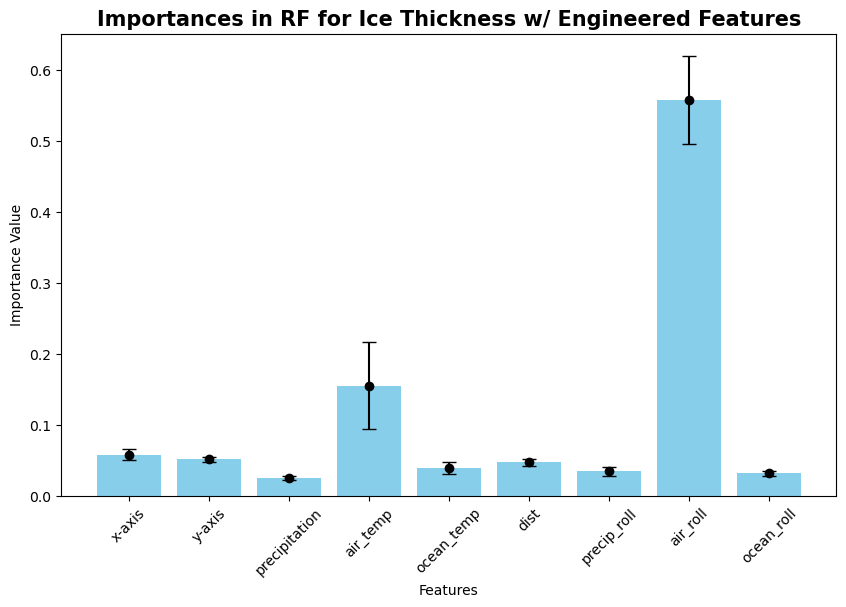

In [45]:
plot_importance(importances_IT_df,IT_std_importances, "Importances in RF for Ice Thickness w/ Engineered Features" )

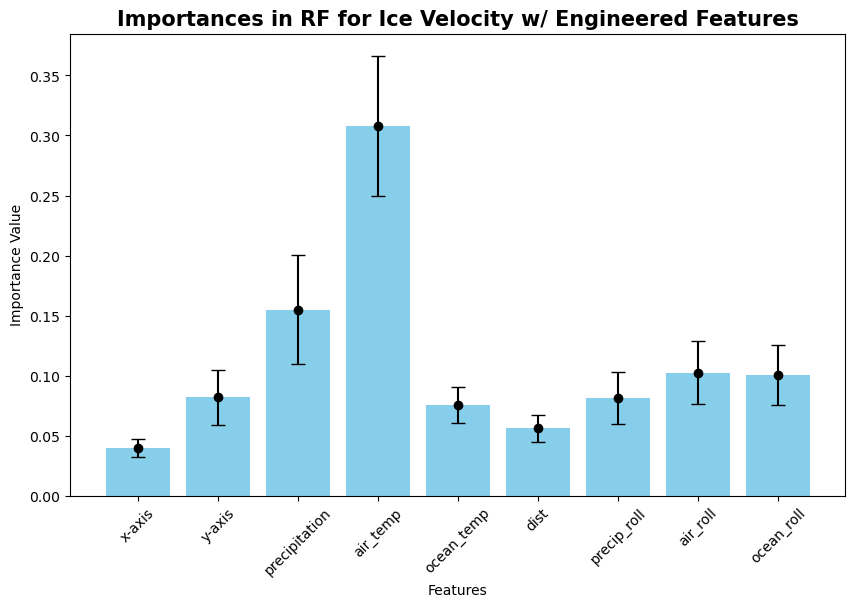

In [46]:
plot_importance(importances_IV_df,IV_std_importances, "Importances in RF for Ice Velocity w/ Engineered Features" )